In [1]:
import torch
import pandas as pd

from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader


In [2]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [3]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values.argmax(1)
etiquetasN = Clases

In [4]:
features = 'PANNs'#'YAMNet' #'VGGish'#'AI'

train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract=features)
print(len(train_dataset))

92


In [5]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

0
RZUA01
file_path='/media/andrescastro/Seagate Backup Plus Drive/AECO/DeepFeatures_data/ReyZamuro/RZUA01_panns.pickle'
n_feat=2048
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
Data1.shape=torch.Size([3, 24, 2048])
1
RZUA02
file_path='/media/andrescastro/Seagate Backup Plus Drive/AECO/DeepFeatures_data/ReyZamuro/RZUA02_panns.pickle'
n_feat=2048
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
Data1.shape=torch.Size([3, 24, 2048])
2
RZUA04
file_path='/media/andrescastro/Seagate Backup Plus Drive/AECO/DeepFeatures_data/ReyZamuro/RZUA04_panns.pickle'
n_feat=2048
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20

In [6]:
x.shape

torch.Size([3, 92, 24, 2048])

## Edge Creation

In [7]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [8]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=11)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1260]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1260]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1260]) connected? True
Is the graph undirected True


In [9]:
graphs_ = edge_creation_nodeinfo(x,'knn', k_neigh=93)
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 24, 2048], edge_index=[2, 8372]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 8372]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 8372]) connected? True
Is the graph undirected True


In [10]:
df_map = pd.read_csv('./data/ReyZamuro_latlon.csv',index_col='field_numb')
df_map = df_map.drop('RZUA03b')

In [11]:
graphs_, adjacency_matrix = edge_creation_geoDistance(x, df_map)

In [12]:
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1400]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1400]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1400]) connected? True
Is the graph undirected True


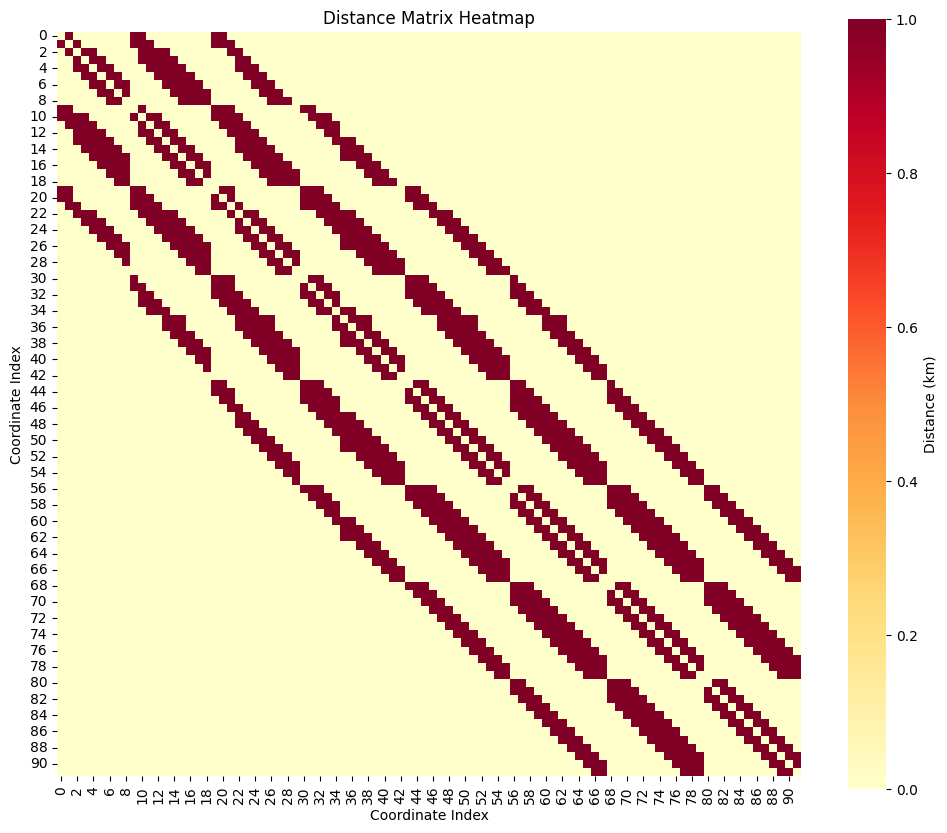

In [13]:
plot_distance_matrix_heatmap(adjacency_matrix)

In [14]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

## Organizar de acá en adelante

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

class MatrixGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, embedding_dim):
        super(MatrixGCN, self).__init__()
        self.conv1d = torch.nn.Conv1d(1, 64, 24, stride=24)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, embedding_dim)

    def forward(self, x, edge_index):
        x = x.transpose(1,2).flatten(1)  # Flatten the matrix features
        x = self.conv1d(x.unsqueeze(1))
        x = x.view(x.size(0),-1)
        #print(x.shape)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize model and optimizer
model = MatrixGCN(in_channels=64*2048, hidden_channels=2048, embedding_dim=8)#num_filters conv1d x num_original_features
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Unsupervised loss function (e.g., graph regularization)
def unsupervised_loss(embedding, edge_index):
    # This loss encourages connected nodes to have similar embeddings
    src, dst = edge_index
    distance = F.pairwise_distance(embedding[src], embedding[dst])
    return distance.mean()

# Training function
def train():
    model.train()
    model.double()
    for graph in train_loader:
        optimizer.zero_grad()
        embedding = model(graph.x.double(), graph.edge_index)
        loss = unsupervised_loss(embedding, graph.edge_index)
        loss.backward()
        optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 12): #Oversmoothing?
    loss = train()
    if epoch % 3 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 003, Loss: 13.4625
Epoch: 006, Loss: 5.9474
Epoch: 009, Loss: 3.3018


In [16]:
# Generate embeddings
model.eval()
with torch.no_grad():
    for graph in train_loader:
        embeddings = model(graph.x.double(), graph.edge_index)

# Function to perform clustering and evaluate
def cluster_and_evaluate(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(embeddings.numpy())
    silhouette_avg = silhouette_score(embeddings.numpy(), clusters)
    return clusters, silhouette_avg

# Try different numbers of clusters
best_n_clusters = 0
best_silhouette = -1
for n_clusters in range(2, 10):  # Try 2 to 10 clusters
    clusters, silhouette_avg = cluster_and_evaluate(embeddings, n_clusters)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is : {silhouette_avg}")
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_n_clusters = n_clusters

print(f"\nBest number of clusters: {best_n_clusters}")

# Perform final clustering with the best number of clusters
final_clusters, _ = cluster_and_evaluate(embeddings, best_n_clusters)

print("\nFinal Clustering Results:")
for i in range(best_n_clusters):
    print(f"Cluster {i}: {(final_clusters == i).sum()} nodes")

# Example: Find similar nodes
def find_similar_nodes(node_idx, top_k=5):
    node_embedding = embeddings[node_idx].unsqueeze(0)
    distances = F.cosine_similarity(node_embedding, embeddings)
    top_similar = torch.topk(distances, k=top_k+1)
    return top_similar.indices[1:].tolist()  # Exclude the node itself

# Find similar nodes for the first node
similar_nodes = find_similar_nodes(0)
print(f"\nNodes similar to node 0: {similar_nodes}")

For n_clusters = 2, the average silhouette score is : 0.559362976110945
For n_clusters = 3, the average silhouette score is : 0.4771973061854289
For n_clusters = 4, the average silhouette score is : 0.4366388929671141
For n_clusters = 5, the average silhouette score is : 0.4051813119162399
For n_clusters = 6, the average silhouette score is : 0.40516383913513604
For n_clusters = 7, the average silhouette score is : 0.416092187676671
For n_clusters = 8, the average silhouette score is : 0.38784180596304
For n_clusters = 9, the average silhouette score is : 0.4229220575642575

Best number of clusters: 2

Final Clustering Results:
Cluster 0: 30 nodes
Cluster 1: 62 nodes

Nodes similar to node 0: [0, 1, 33, 21, 43]


In [17]:
graph

DataBatch(x=[92, 24, 2048], edge_index=[2, 1260], batch=[92], ptr=[2])

In [18]:
print(embeddings.shape)
embeddings = (embeddings - embeddings.min(0).values)/(embeddings.max(0).values - embeddings.min(0).values)

torch.Size([92, 8])


In [19]:
import colorsys
import plotly.graph_objs as go


# Sample data
locations = df_map.reset_index().rename(columns={'index': 'name'}).to_dict('records')

def generate_colors(n):
    HSV_tuples = [(x * 1.0 / n, 0.7, 0.7) for x in range(n)]
    return list(map(lambda x: f'rgb{tuple(round(i * 255) for i in colorsys.hsv_to_rgb(*x))}', HSV_tuples))


# color_map = {0: 'red', 1: 'blue', 2:'green'}
unique_labels = list(set(final_clusters))
colors = generate_colors(len(unique_labels))
color_map = dict(zip(unique_labels, colors))

# Create traces
traces = []
for location, label in zip(locations, final_clusters):
    traces.append(
        go.Scattermapbox(
            lat=[location['latitude_IG']],
            lon=[location['longitud_IG']],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=14,
                color=color_map[label],
                opacity=0.8
            ),
            text=[f"{location['field_numb']} ({label})"],
            name=location['field_numb'],
            showlegend=True
        )
    )

# Create layout
layout = go.Layout(
    mapbox=dict(
        style="open-street-map",
        # center=dict(lat=39, lon=-98),  # Center of the US
        center=dict(lat=df_map.mean().values[0], lon=df_map.mean().values[1]),
        zoom=11.7
    ),
    showlegend=True
)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

## Grafo nuevo (calcular aristas de nuevo con información de nodo) 

In [20]:
embeddings.shape

torch.Size([92, 8])

In [21]:
graphs_ = edge_creation_nodeinfo(embeddings.unsqueeze(0),'knn', k_neigh=1)
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 8], edge_index=[2, 124]) connected? False
Is the graph undirected True


In [22]:
graphs[0].edge_index.shape

torch.Size([2, 1260])

In [23]:
graphs_[0].edge_index.shape

torch.Size([2, 124])

In [24]:
from utils import edge_index_to_adjacency

In [25]:
adj_init = edge_index_to_adjacency(graphs[0].edge_index)

In [26]:
adj_final = edge_index_to_adjacency(graphs_[0].edge_index)

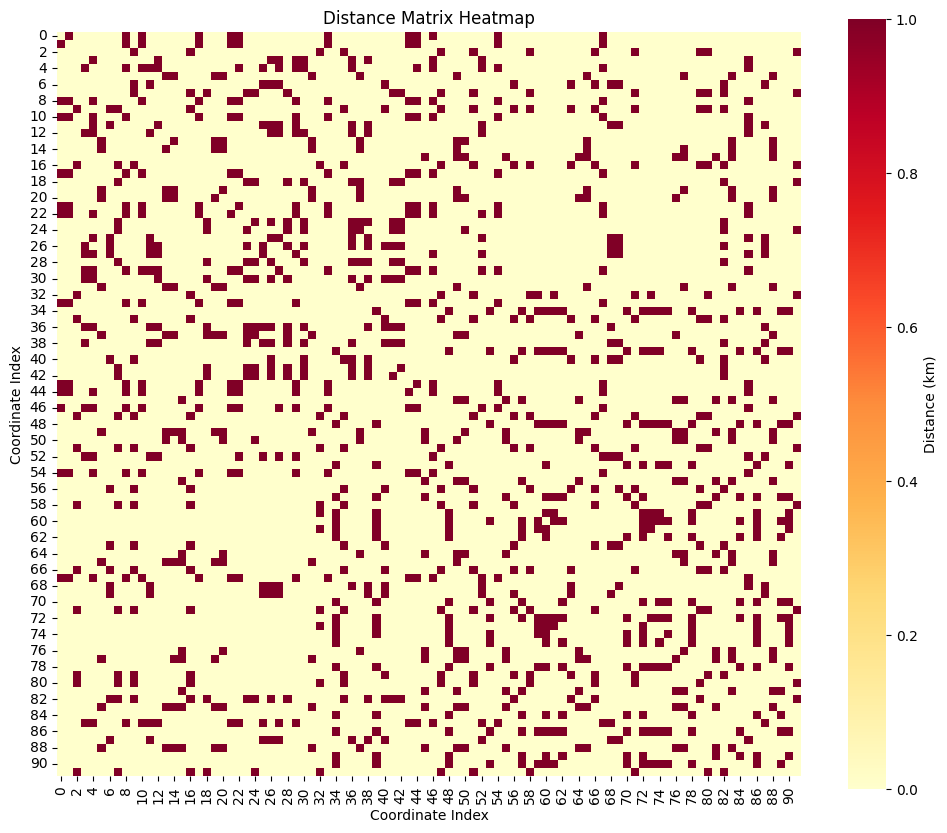

In [27]:
plot_distance_matrix_heatmap(adj_init)

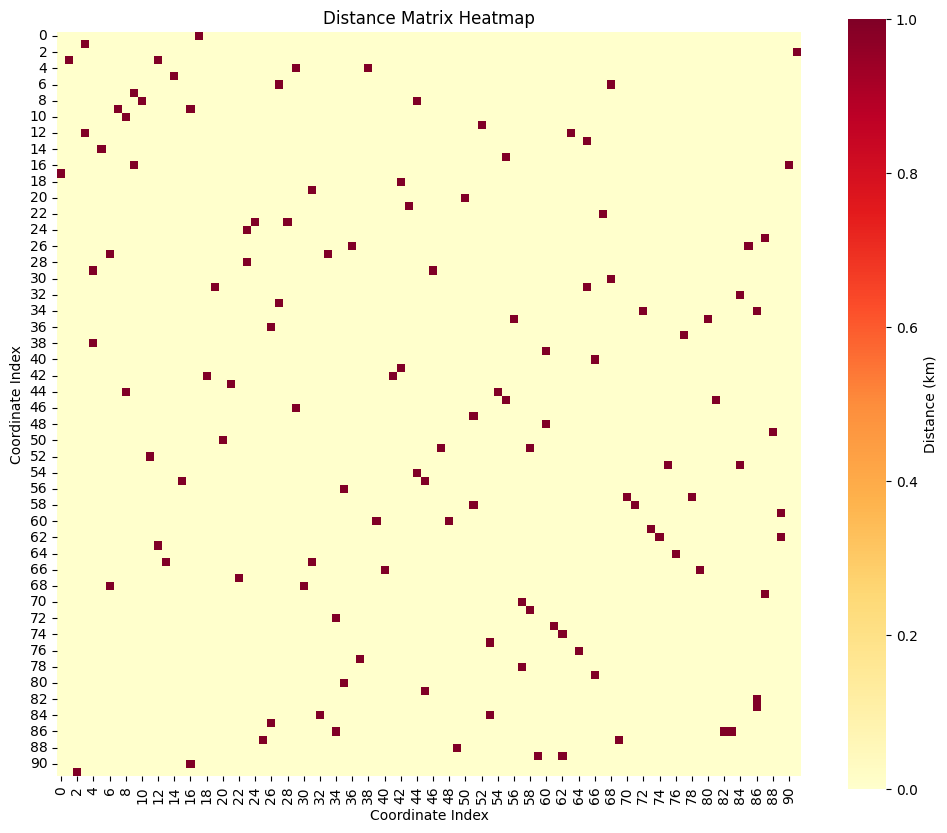

In [28]:
plot_distance_matrix_heatmap(adj_final)

In [29]:
df_map

,latitude_IG,longitud_IG
field_numb,,
RZUA01,3.555860,-73.411659
RZUA02,3.552269,-73.411659
RZUA04,3.544981,-73.411514
RZUA05,3.541357,-73.411571
RZUA06,3.537848,-73.411489
...,...,...
RZUH09,3.527172,-73.386423
RZUH10,3.523509,-73.386542
RZUH11,3.519590,-73.386250


In [30]:
import geopandas as gpd
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [31]:
#función que permite plotear nodos en posición geográfica deseada
def same_posicion_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud_IG, df.latitude_IG)) #objeto geometrico para respetar posiciones
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

In [32]:
coordinates = same_posicion_data(df_map)

In [33]:
graphs_[0]

Data(x=[92, 8], edge_index=[2, 124])

In [34]:
coordinates

array([[-73.411659 ,   3.55586  ],
       [-73.4116585,   3.5522694],
       [-73.4115144,   3.5449814],
       [-73.4115714,   3.541357 ],
       [-73.4114886,   3.5378482],
       [-73.4113688,   3.53451  ],
       [-73.4116395,   3.5306852],
       [-73.4120533,   3.5270875],
       [-73.4117267,   3.5232767],
       [-73.4080305,   3.5558748],
       [-73.4079323,   3.548788 ],
       [-73.408125 ,   3.5452143],
       [-73.4080353,   3.5414035],
       [-73.4073639,   3.5377706],
       [-73.4079365,   3.5339204],
       [-73.4078713,   3.5305841],
       [-73.4079213,   3.5269836],
       [-73.4083064,   3.5235147],
       [-73.4076433,   3.520385 ],
       [-73.4046697,   3.5556609],
       [-73.4042293,   3.5522801],
       [-73.4044693,   3.5486698],
       [-73.4043366,   3.5414907],
       [-73.4043351,   3.537707 ],
       [-73.4044158,   3.5340425],
       [-73.404327 ,   3.5306657],
       [-73.4042486,   3.5269262],
       [-73.4041044,   3.5234838],
       [-73.4044419,

In [35]:
graphs_[0]

Data(x=[92, 8], edge_index=[2, 124])

In [36]:
def pyg_to_networkx(data):
    # Convert PyG data to NetworkX graph
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(range(data.num_nodes))
    
    # Add edges
    edges = data.edge_index.t().numpy()
    G.add_edges_from(edges)
    
    # Optionally add node and edge attributes
    if data.x is not None:
        nx.set_node_attributes(G, {i: data.x[i].numpy() for i in range(data.num_nodes)}, 'features')
    
    if data.edge_attr is not None:
        edge_attrs = {tuple(edge): data.edge_attr[i].numpy() for i, edge in enumerate(edges)}
        nx.set_edge_attributes(G, edge_attrs, 'attributes')
    
    return G

In [68]:
G = pyg_to_networkx(graphs_[0])
nodes = list(G.nodes())
positions = dict(zip(G.nodes, coordinates))

In [69]:
edge_weights = [1 for u, v in G.edges()]

/home/andrescastro/miniconda3/envs/PytorchGeometric/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



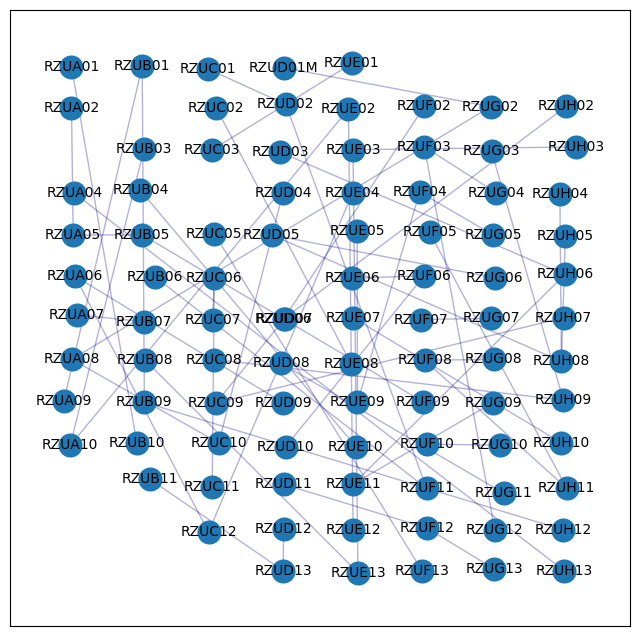

In [70]:
# Dibujar los nodos del grafo con tamaño personalizado
node_size = 300
# node_color = colores
node_border_color = 'white'
node_border_width = 0
node_labels = {node: df_map.index[node] for node in G.nodes()}

fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_nodes(graphs_[0], positions, nodelist=G.nodes(), node_size=node_size,# node_color=node_color,
                       linewidths=node_border_width, edgecolors=node_border_color, cmap="summer")
nx.draw_networkx_labels(G, positions, labels=node_labels, font_color='black', font_size=10)

# escalar los anchos de los enlaces
min_width = 1  # ancho mínimo de enlace
max_width = 5  # ancho máximo de enlace
# scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights] #si valor de enlace es cercano al umbral, el color se acercará al azul, si es mucho mayor al umbral se acerca al rojo


# Dibujar los enlaces del grafo con ancho constante y colores personalizados
nx.draw_networkx_edges(G, positions, width=edge_weights, edge_color="darkblue", alpha=0.3) # se puede ver tambien con colores cambiando edge_color=edge_colors
# fig.savefig('./results/graph_geo.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=0.0)

In [71]:
import seaborn as sns

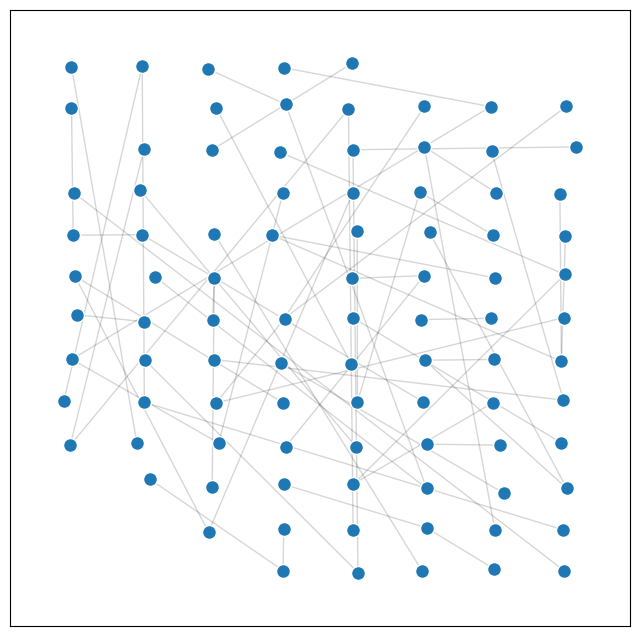

In [72]:
# with plt.style.context("seaborn-v0_8-whitegrid"):
fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_nodes(G, pos=positions, ax=ax, node_size=100, edgecolors="white", linewidths=1)
nx.draw_networkx_edges(G, pos=positions, width=edge_weights, alpha=0.1618, ax=ax)
fig.savefig(f'./results/graph_edges_{features}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=-0.4)

In [42]:
from datashader.bundling import hammer_bundle

/home/andrescastro/miniconda3/envs/PytorchGeometric/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




In [43]:
nodes_py = [[name, a[0], a[1]] for name, a in zip(nodes, positions.values())]
ds_nodes = pd.DataFrame(nodes_py, columns=['name', 'x', 'y'])       

ds_edges_py = [[n0, n1] for (n0, n1) in G.edges]
ds_edges = pd.DataFrame(ds_edges_py, columns=['source', 'target'])

hb = hammer_bundle(ds_nodes, ds_edges)

<Axes: xlabel='x'>

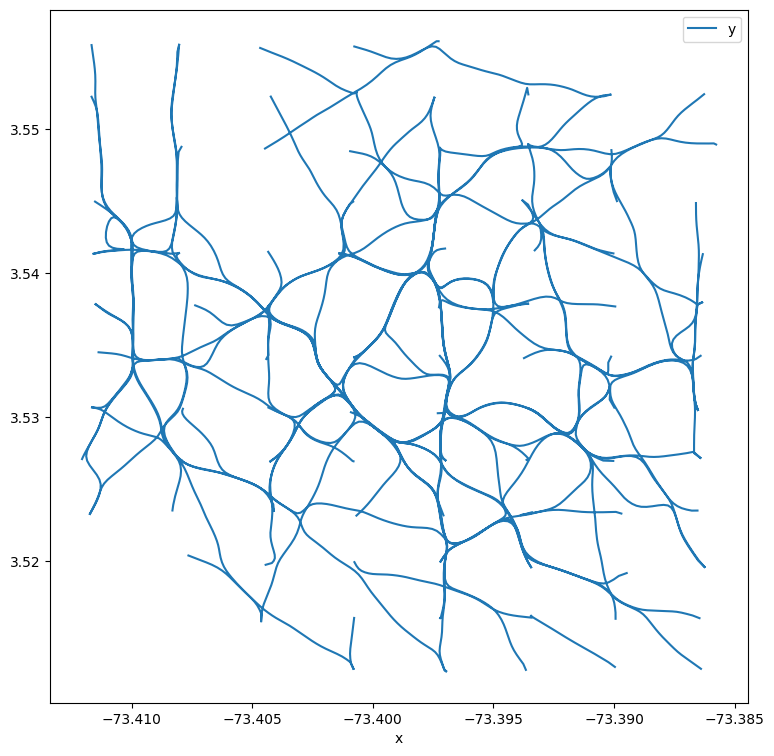

In [44]:
hb.plot(x="x", y="y", figsize=(9,9))

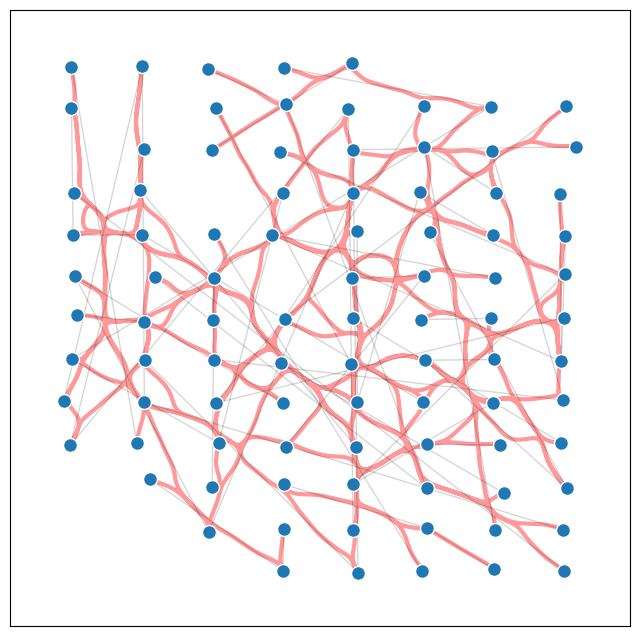

In [45]:
# with plt.style.context("seaborn-v0_8-whitegrid"):
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(hb.x, hb.y, 'r', zorder=1, linewidth=3, alpha=0.4)
nx.draw_networkx_nodes(G, pos=positions, ax=ax, node_size=100, edgecolors="white", linewidths=1)
nx.draw_networkx_edges(G, pos=positions, width=edge_weights, alpha=0.1618, ax=ax)
fig.savefig(f'./results/graph_edgebund_{features}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=-0.4)

In [46]:
# Extract latitudes and longitudes from dataframe
locations = df_map.reset_index().rename(columns={'index': 'name'})
lats = locations['latitude_IG'].values
lons = locations['longitud_IG'].values

bounds = (np.min(lats), np.max(lats), np.min(lons), np.max(lons))

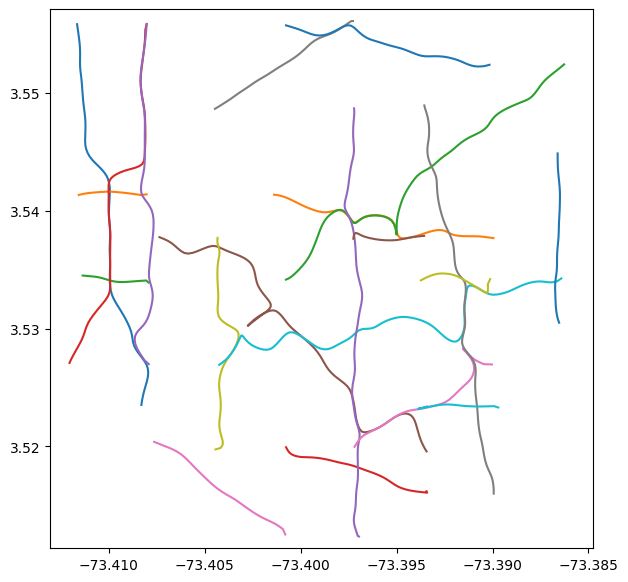

In [47]:
hbnp = hb.to_numpy()
splits = (np.isnan(hbnp[:,0])).nonzero()[0]

start = 0
segments = []
for stop in splits:
    seg = hbnp[start:stop, :]
    segments.append(seg)
    start = stop

fig, ax = plt.subplots(figsize=(7,7))
for seg in segments[::3]:
    ax.plot(seg[:,0], seg[:,1])
    ax.set_xlim(bounds[2]-0.001, bounds[3]+0.001)
    ax.set_ylim(bounds[0]-0.001, bounds[1]+0.001)

/home/andrescastro/miniconda3/envs/PytorchGeometric/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



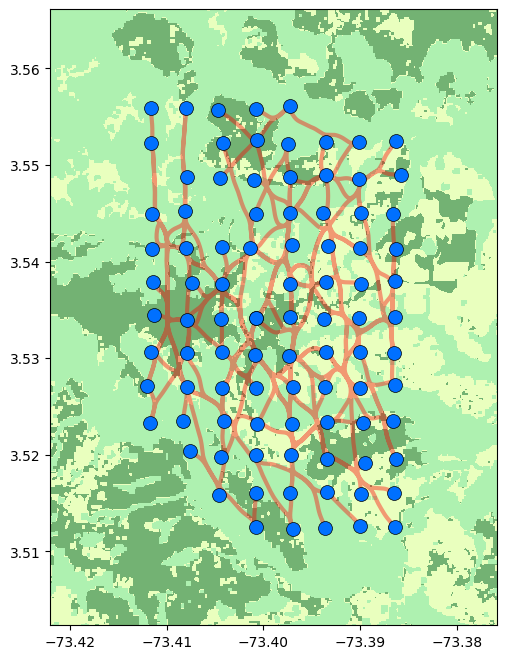

In [48]:
from matplotlib.colors import LinearSegmentedColormap
import rasterio
from rasterio.plot import show

colors = [(115/255,178/255,115/255),(233/255,255/255,190/255), (174/255,241/255,176/255)] 
cmap = LinearSegmentedColormap.from_list('my_cmp', colors, N=3)


tif_path = r'./data/wgs84.tif'

img = rasterio.open(tif_path)

fig, ax = plt.subplots(figsize = (8, 8))

# plt.title("COB")
r = rasterio.plot.show(img, cmap=cmap, ax=ax)

# im = r.get_images()[0]
# fig.colorbar(im, ax=ax)


nx.draw_networkx_nodes(G, pos=positions, ax=ax, node_size=100, edgecolors="black", linewidths=0.5, node_color=(0,112/255,255/255), hide_ticks=False)
# nx.draw_networkx_edges(G, pos=positions, width=edge_weights, alpha=0.618, ax=ax, hide_ticks=False)
ax.plot(hb.x, hb.y, 'r', zorder=1, linewidth=3, alpha=0.4)


margin = 0.01
ax.set_xlim(bounds[2]-margin, bounds[3]+margin)
ax.set_ylim(bounds[0]-margin, bounds[1]+margin)

fig.savefig(f'./results/graph_eb_geo_{features}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=-0.4)
plt.show()


In [49]:
embeddings.shape

torch.Size([92, 8])

In [50]:
df_map

,latitude_IG,longitud_IG
field_numb,,
RZUA01,3.555860,-73.411659
RZUA02,3.552269,-73.411659
RZUA04,3.544981,-73.411514
RZUA05,3.541357,-73.411571
RZUA06,3.537848,-73.411489
...,...,...
RZUH09,3.527172,-73.386423
RZUH10,3.523509,-73.386542
RZUH11,3.519590,-73.386250


In [51]:
df_inter = pd.DataFrame(embeddings, columns=[f'col_{i}' for i in range(embeddings.shape[1])])
# df_inter = pd.concat([df_inter, df_map], axis=1)
df_inter = pd.concat([ df_map.reset_index(), df_inter.reset_index()], axis=1)
df_inter

,field_numb,latitude_IG,longitud_IG,index,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,RZUA01,3.555860,-73.411659,0,0.869026,0.101696,0.124509,0.885507,0.099170,0.899971,0.210715,9.545001e-01
1,RZUA02,3.552269,-73.411659,1,1.000000,0.000000,0.007910,1.000000,0.000000,1.000000,0.084140,1.000000e+00
2,RZUA04,3.544981,-73.411514,2,0.776785,0.305732,0.207244,0.858055,0.350931,0.711061,0.120764,6.262232e-01
3,RZUA05,3.541357,-73.411571,3,0.995857,0.068215,0.002465,0.895432,0.056988,0.922316,0.116356,8.484721e-01
4,RZUA06,3.537848,-73.411489,4,0.289359,0.608007,0.629789,0.309635,0.587775,0.389346,0.794763,6.383740e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
87,RZUH09,3.527172,-73.386423,87,0.820702,0.212722,0.121822,0.774248,0.194234,0.771540,0.247511,7.971008e-01
88,RZUH10,3.523509,-73.386542,88,0.080388,1.000000,1.000000,0.000000,1.000000,0.000000,0.906622,5.544179e-16
89,RZUH11,3.519590,-73.386250,89,0.809753,0.401807,0.219813,0.818511,0.311513,0.625926,0.165759,4.955795e-01
90,RZUH12,3.516031,-73.386458,90,0.329559,0.809881,0.647861,0.423313,0.688592,0.235505,0.627213,2.925352e-01


In [52]:
embeddings[:,0]

tensor([0.8690, 1.0000, 0.7768, 0.9959, 0.2894, 0.9303, 0.6960, 0.3346, 0.5042,
        0.3003, 0.5042, 0.5869, 0.9947, 0.9372, 0.9303, 0.9349, 0.2828, 0.8690,
        0.9769, 0.9303, 0.6763, 0.6193, 0.3823, 0.8360, 0.8413, 0.8259, 0.2586,
        0.7477, 0.8360, 0.2963, 0.7501, 0.9303, 0.9140, 0.7433, 0.1115, 0.5446,
        0.2759, 0.4557, 0.3786, 0.2170, 0.4272, 0.9773, 0.9773, 0.6193, 0.5042,
        0.9355, 0.2798, 0.5204, 0.2260, 0.0804, 0.6718, 0.5204, 0.6356, 0.9598,
        0.5042, 0.9355, 0.5445, 0.5577, 0.5204, 0.7925, 0.2230, 0.9161, 0.8217,
        0.9477, 0.7978, 0.9351, 0.4193, 0.3823, 0.6891, 0.8190, 0.5824, 0.5204,
        0.1115, 0.9198, 0.8241, 0.9672, 0.7978, 0.4281, 0.4561, 0.4217, 0.6461,
        0.9395, 0.0000, 0.1955, 0.9495, 0.0790, 0.1115, 0.8207, 0.0804, 0.8098,
        0.3296, 0.7804], dtype=torch.float64)

In [53]:
df_inter.iloc[35]

field_numb        RZUD06
latitude_IG     3.534165
longitud_IG   -73.400769
index                 35
col_0           0.544561
col_1           0.468938
col_2            0.38992
col_3            0.64961
col_4           0.503603
col_5           0.533111
col_6            0.36692
col_7           0.571809
Name: 35, dtype: object

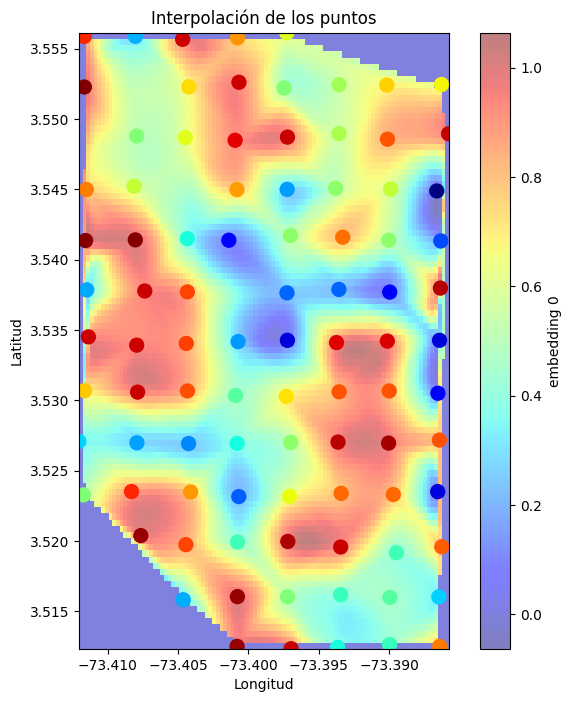

In [54]:
from shapely.geometry import Point
from scipy.interpolate import griddata

emb_sel = 0
col_sel = f'col_{emb_sel}'


# Crear un GeoDataFrame a partir del DataFrame, utilizando XCOORD.y e YCOORD.y como coordenadas de geometría
geometry = [Point(xy) for xy in zip(df_inter['longitud_IG'], df_inter['latitude_IG'])]
gdf = gpd.GeoDataFrame(df_inter, geometry=geometry)
gdf.drop(35, inplace=True)

# Cargar el archivo TIF para obtener los límites del mapa
tif_path = './data/wgs84.tif'

with rasterio.open(tif_path) as tif:
    bounds_t = tif.bounds

# Define la resolución de la cuadrícula para la interpolación
resolution = 100

# Crea una cuadrícula regular para la interpolación
x_min, x_max = gdf['longitud_IG'].min(), gdf['longitud_IG'].max()
y_min, y_max = gdf['latitude_IG'].min(), gdf['latitude_IG'].max()
x_grid = np.linspace(x_min, x_max, resolution)
y_grid = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x_grid, y_grid)

# Realiza la interpolación utilizando griddata
Z2 = griddata((gdf['longitud_IG'], gdf['latitude_IG']), gdf[col_sel], (X, Y), method='cubic',fill_value=0)

fig, ax = plt.subplots(figsize=(8,8))

# Visualiza los puntos originales
gdf.plot(ax=ax, column=col_sel, cmap='jet', markersize=100)#, legend=True)

# Visualiza la interpolación como un mapa de calor
im = ax.imshow(Z2, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='jet', alpha=0.5)
plt.colorbar(im, ax=ax, label=f'embedding {emb_sel}')
limited_dataimg = im.get_array()

# ax.plot(hb.x, hb.y, 'r', zorder=1, linewidth=3, alpha=0.4)

ax.set_title('Interpolación de los puntos')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
plt.show()

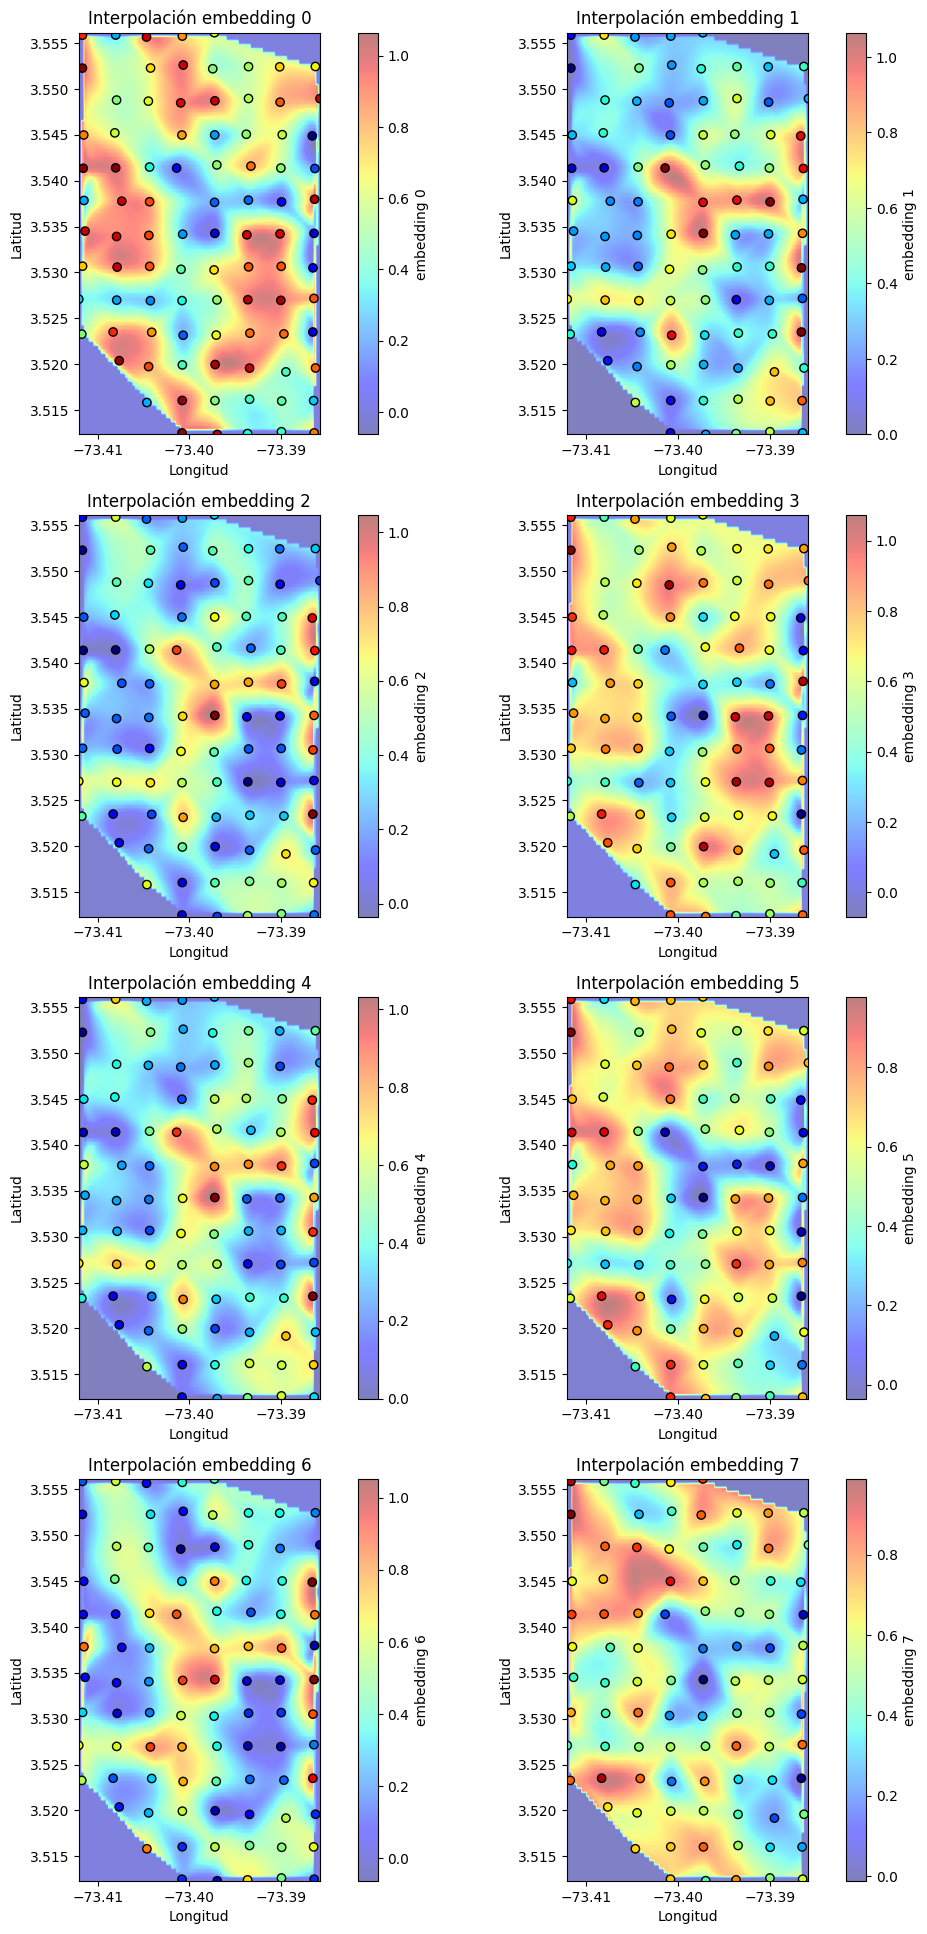

In [55]:
# Create a 4x2 subplot grid
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = axes.ravel()  # Flatten the 2D array of axes for easier iteration

# Cargar el archivo TIF para obtener los límites del mapa
tif_path = './data/wgs84.tif'
with rasterio.open(tif_path) as tif:
   bounds_t = tif.bounds

# Define la resolución de la cuadrícula para la interpolación
resolution = 100

# Crear un GeoDataFrame a partir del DataFrame
geometry = [Point(xy) for xy in zip(df_inter['longitud_IG'], df_inter['latitude_IG'])]
gdf = gpd.GeoDataFrame(df_inter, geometry=geometry)
gdf.drop(35, inplace=True)

# Crea una cuadrícula regular para la interpolación
x_min, x_max = gdf['longitud_IG'].min(), gdf['longitud_IG'].max()
y_min, y_max = gdf['latitude_IG'].min(), gdf['latitude_IG'].max()
x_grid = np.linspace(x_min, x_max, resolution)
y_grid = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x_grid, y_grid)

# Generar gráficas para cada embedding
for emb_sel in range(8):
   col_sel = f'col_{emb_sel}'
   
   # Realiza la interpolación utilizando griddata
   Z2 = griddata((gdf['longitud_IG'], gdf['latitude_IG']), gdf[col_sel], (X, Y), method='cubic', fill_value=0)
   
   # Selecciona el subplot actual
   ax = axes[emb_sel]
   
   # Visualiza la interpolación como un mapa de calor
   im = ax.imshow(Z2, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='jet', alpha=0.5)
   
   # Añade los puntos originales
   scatter = ax.scatter(gdf['longitud_IG'], gdf['latitude_IG'], c=gdf[col_sel], cmap='jet', edgecolors='black')
   
   # Añade colorbar
   plt.colorbar(im, ax=ax, label=f'embedding {emb_sel}')
   
   # Configura título y etiquetas
   ax.set_title(f'Interpolación embedding {emb_sel}')
   ax.set_xlabel('Longitud')
   ax.set_ylabel('Latitud')

# Ajusta el layout para evitar solapes
plt.subplots_adjust(wspace=-0.35, hspace=0.2)

fig.savefig(f'./results/interp_emb_{features}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=0.0)


# Muestra todas las gráficas
plt.show()
